In [1]:
import arviz
import cmdstanpy
from IPython.display import display
from matplotlib import pyplot as plt
from numbers import Number
import numpy as np
import os
import pandas as pd
from pandas.io.json import json_normalize
import toml
plt.style.use('sparse.mplstyle')

# Modelling networks of metabolic reactions with Stan

Many useful substances can be produced using chemical reactions that happen inside living organisms like _E. Coli,_ yeast or Chinese hamster ovaries. Biological production is appealing because it can be done in relatively mild conditions. On the other hand, biological production depends on complex networks of interacting enzyme-catalysed chemical reactions which can be difficult to understand, manipulate and optimise.

This notebook describes how to analyse metabolic networks by integrating different sources of information - structural knowledge, pre-experimental information about parameters and experiment results - using Bayesian inference.

## Wait, what is an enzyme-catalysed reaction?
An enzyme is a 'catalyst' protein that speeds up a chemical reaction by binding the reactants to an 'active site' where the conditions for the reaction are favourable. This visualisation gives an idea of how this process is thought to work: 

![Enzyme Action and the Hydrolysis of Sucrose [HD Animation]](https://i.makeagif.com/media/9-16-2015/SIif27.gif)

## Structural information 

The topological structure of most industrially relevant metabolic networks has been mapped. It is usually known which substances go in and out of each reaction the enzyme that catalyses it. Often there is even more structural information, such as what shape the enzyme has, which substances can bind to its active site.

This information is available online, for example in the [BIGG database](http://bigg.ucsd.edu/). 

Here is a reduced map of yeast central metabolism, with nodes representing metabolites and edges representing reactions: 

<img src="img/yeast_central_metabolism.png" alt="Drawing" style="width: 600px;"/>

Finer-grained structural information can be used to deduce the mechanism by which each enzyme operates. A mechanism, in turn, implies a way of parameterising the rate at which an enzyme turns substrates into products. For example, the following equation describes how the rate $v$ of a 'uni-uni' mechanism (See [Cleland (1963)](https://doi.org/10.1016/0926-6569%2863%2990211-6) for more about mechanisms in general and derivations of particular mechanisms used in this analysis) with no activators or inhibitors depends on the current concentration of its substrate $A$ and product $P$, as well as parameters $K_{eq}$, $K_{a}$, $V1$ and $V2$:

$$
\begin{equation}
v = \frac{V1\cdot{V2}\cdot{(A-P/K_{eq})}}{K_{a}\cdot{V2} + V2\cdot{A} + V1\cdot{P/K_{eq}}}
\end{equation}
$$

The main output of this analysis will be inference about the values of this kind of parameter.


## Pre-experimental information
Most parameters are difficult to assess because the conditions inside a cell are difficult to replicate _in vitro_. See [Saa and Keld Nielsen (2017)](https://doi.org/10.1016/j.biotechadv.2017.09.005) for more about top-down vs bottom-up parameter estimation. Nonetheless, a lot of information is available.

For kinetic parameters it is possible to use the 'Respectful' modelling paradigm (see [Tsigkinopoulou, Baker, and Breitling (2017)](https://doi.org/10.1016/j.tibtech.2016.12.008)) to aggregate the results of findings about kinetic parameters published in the [BRENDA enzyme database](https://www.brenda-enzymes.org/), as well as assessments of thermodynamic parameters from the [equilibrator database](http://equilibrator.weizmann.ac.il/). This analysis produces an independent normal or log-normal distribution representing the pre-experimental information available about each parameter.

## Experimental information

Modern experimental techniques measure the following quantities:

- Enzyme concentrations (_proteomics_)
- Metabolite concentrations (_metabolomics_)
- Rates of reactions, aka fluxes (_fluxomics_)

Each kind of measurement is noisy.

## Modelling strategy

We are proposing to use Bayesian inference to combine all the available sources of information about a metabolic network.

Pre-experimental information supplies informative prior probability distributions about the parameters that describe each reaction.

We treat information from metabolomics and fluxomics data using a regression model where recorded values of measured quantities are draws from distributions centered on the true values as follows, with indexes $e$ standing for experiments, $f$ for fluxes and $m$ for metabolites:

$$
measured\, flux_{f,e} \sim Normal(true\, flux_{f,e}, \sigma_{f,e}) \\
measured\, metabolite\, concentration_{m,e} \sim Lognormal(\log(true\, metabolite\, concentration_{m,e}), \sigma_{m,e})
$$

Structural information can be used to connect the other two sources of information by mapping parameter configurations to true metabolite concentrations and fluxes. This is done by expressing the evolution of each metabolite's concentration as a system of ordinary differential equations, with the rate of change of each metabolite determined by the rates of the reactions that produce and consume it. We assume that, at the time of measurement, the concentration of the network's internal metabolites is constant, or in other words that the system has reached a steady state. In general, a vector $\mathbf{v}$ of steady state fluxes must satisfy the following condition

$$
S\cdot\mathbf{v} = \mathbf{0}
$$

Where $S$ is a known 'stoichiometric matrix' indicating which reactions produce and consume which metabolites and $\mathbf{0}$ is a vector of as many zeros as the network has internal metabolites. Given a parameter configuration, a steady state metabolite concentration can be found by solving the resulting system of algebraic equations. 

We solve these equation systems by integrating the implied ODEs over a period of time for which it is safe to assume that the system has reached steady state.

This approach is essentially the same as that set out by [Saa and Keld Nielsen (2016)](https://doi.org/10.1038/srep29635), but uses MCMC via Stan rather than rejection sampling to make inferences. Thanks to Stan's intuitive model language, this approach and attendant assumptions can be represented in a more or less self-documenting form.


## Example - a simple linear system

The rest of the notebook applies this modelling strategy to investigate how accurately it is possible to find out the value of the kinetic parameters and steady state metabolite concentrations of the simple metabolic network depicted below, given a known experimental setup and prior information.

<img src="img/linear.png" alt="Drawing" style="width: 800px;"/>

This network has two internal metabolites, M1 and M2, and three reactions R1, R2 and R3. Metabolites M1 and M2 are measured, and reaction R2 is inhibited by M1. The test tube photos indicate quantities that were measured.

To gauge how accurately the available information identifies the quantities of interest, the notebook uses Stan to generate simulated experimental data given 'true' parameter values, then uses the simulated data as model input. If the model is unable to recover the true value of a parameter, this is may be a sign that the simulated experiment shouldn't be carried out in real life without more diverse or accurate measurements or better pre-experimental information.

## Model input
We are developing an input data format for succinctly expressing the information required to model a metabolic network. Here is what the linear system looks like in this format:

In [2]:
with open('linear.toml', 'r') as f:
    print(f.read())

[constants]
gas_constant = 8.314e-3 # units kJ/mol.K
temperature = 298.15

[[experiment]]
label = 'condition_1'
concentration_r1 = 0.3
concentration_r2 = 4.3
measurements = [
  { label = 'M1', error_scale = 0.1, type = 'metabolite' },
  { label = 'M2', error_scale = 0.1, type = 'metabolite' },
  { label = 'r3', error_scale = 0.02, type = 'flux' }
]

[[experiment]]
label = 'condition_2'
concentration_r1 = 0.2
concentration_r2 = 3.8
measurements = [
  { label = 'M1', error_scale = 0.1, type = 'metabolite' },
  { label = 'M2', error_scale = 0.1, type = 'metabolite' },
  { label = 'r3', error_scale = 0.02, type = 'flux' }
]

[[reaction]]
name = 'r1'
mechanism = 'fixed_flux'
stoichiometry = { M1 = 1 }

[[reaction]]
name = 'r2'
mechanism = 'uniuni'
stoichiometry = { M1 = -1, M2 = 1 }
parameters = [
  { label = 'Keq', prior_loc = 1.1, prior_scale = 0.5, type = 'kinetic', true_value = 4 },
  { label = 'Kcat1', prior_loc = 0, prior_scale = 0.6, type = 'kinetic', true_value = 1.3 },
  { label = 

The `reaction` entries in this file jointly specify the network's stoichiometry, reaction mechanisms, priors and allosteric interactions, while the `experiment` entries describe how the system has been measured, including experimental conditions, measured quantities and accuracies of each measurement. A value for each measurement can also be specified, but here we will simulate these using the specified parameter `true_value`s. It is assumed that all experiments were carried out at the same temperature.

### Allosteric regulation

Allosteric effects occur when an enzyme molecule's shape changes due to substances binding to it, making the enzyme a more or less effective catalyst. Allosteric effects play an important role in regulating metabolic reactions. Following [Popova and Selkov (1975)](https://doi.org/10.1016/0014-5793(75)80034-2), we model allosteric regulation through a function that expresses the overall effect of allosteric factors on the rate of a reaction as a multiplicative factor. Here is what the function looks like in Stan code:

In [3]:
with open('allostery.stan', 'r') as f:
    print(f.read())

real get_free_enzyme_ratio_uniuni(real A, real P, real V1, real V2, real Ka, real Keq){
  real Kp = Keq * V2 * Ka / V1;
  return 1 / (1 + A/Ka + P/Kp);
}
real get_regulatory_effect(real[] activator_concentration,
                           real[] inhibitor_concentration,
                           real free_enzyme_ratio,
                           real[] dissociation_constant_r,
                           real[] dissociation_constant_t,
                           real transfer_constant){
  real Q_num = size(inhibitor_concentration) == 0 ? 1 :
    1 + sum(to_vector(inhibitor_concentration) ./ to_vector(dissociation_constant_t));
  real Q_denom = size(activator_concentration) == 0 ? 1
    : 1 + sum(to_vector(activator_concentration) ./ to_vector(dissociation_constant_r));
  real Q = transfer_constant * free_enzyme_ratio * Q_num / Q_denom;
  return inv(1 + Q); 
}
    



### Rate equations

The following Stan functions describe the catalytic effects of each reaction mechanism that appears in the network we want to analyse

In [4]:
with open('rate_equations.stan', 'r') as f:
    print(f.read())

real uniuni(real A, real P, real V1, real V2, real Ka, real Keq){
  real num = V1*V2*(A-P/Keq);
  real denom = Ka*V2 + V2*A + V1*P/Keq;
  return num / denom;
}
real irr_mass_action(real A, real V1){
  return(A*V1);
}
real fixed_flux(real f){
  return f;
}



### Inference

The model for making inferences is shown below. The `functions` block uses the library functions described above to define an ode function called `steady_state_equation`. This function is called in the `transformed parameters` block in order to obtain metabolite concentrations given parameter values. In the `model` block the values of the variable `metabolite_concentration` are used in the measurement model.




In [5]:
with open('inference_model_linear.stan', 'r') as f:
    print(f.read())

functions {
#include rate_equations.stan
#include allostery.stan
  real[] get_fluxes(real[] metabolites, real[] params, real[] known_reals){
    real empty_array[0];
    real free_enzyme_ratio_r2 = get_free_enzyme_ratio_uniuni(metabolites[1],
                                                             metabolites[2],
                                                             known_reals[2]*params[2],
                                                             known_reals[2]*params[3],
                                                             params[4], params[1]);
    return {
      fixed_flux(known_reals[1]),
      uniuni(metabolites[1], metabolites[2], known_reals[2]*params[2], known_reals[2]*params[3], params[4], params[1])
      * get_regulatory_effect(empty_array, {metabolites[1]}, free_enzyme_ratio_r2, empty_array, {params[5]}, params[6]),
      irr_mass_action(metabolites[2], params[7])
    };
  }
  real[] get_odes(real[] fluxes){
    return {
      1*fluxes[1]-1*fluxes[2

### Data munging

The code in the following cell reads the data from the input file and organises it into pandas and python objects that can be used as input for Stan.

In [6]:
def get_numerical_entries(d: dict):
    """Returns a dictionary of entries in d where the value is a Number"""
    return dict(filter(lambda i: isinstance(i[1], Number), d.items()))


data = toml.load('linear.toml')
# Map metabolite, reaction and experiment names to 1-indexed codes
metabolite_names = list(set(*zip(*[r['stoichiometry'].keys() for r in data['reaction']])))
reaction_names = [r['name'] for r in data['reaction']]
experiment_names = [e['label'] for e in data['experiment']]
metabolite_codes = pd.Series(range(1, len(metabolite_names) + 1), 
                             index=metabolite_names,
                             name='metabolite_code')
reaction_codes = pd.Series(range(1, len(reaction_names) + 1), 
                             index=reaction_names,
                             name='reaction_code')
experiment_codes = pd.Series(range(1, len(experiment_names) + 1), 
                             index=experiment_names,
                             name='experiment_code')
# Dataframes of measurements, known reals and parameters
measurements = (
    json_normalize(data['experiment'], record_path='measurements', meta='label', meta_prefix='experiment_')
    .set_index('type')
    .rename(columns={'experiment_label': 'experiment'})
    .join(experiment_codes, on='experiment')
)
flux_measurements = measurements.loc['flux'].join(reaction_codes, on='label')
conc_measurements = measurements.loc['metabolite'].join(metabolite_codes, on='label')
known_reals = pd.DataFrame({e['label']: {**get_numerical_entries(e), **data['constants']} 
                            for e in data['experiment']})
for r in data['reaction']:  # json_normalize doesn't like missing values in record path
    if 'parameters' not in r.keys():
        r['parameters'] = []
parameters = (
    json_normalize(
        data['reaction'], 
        record_path='parameters',
        meta=['name']
    )
    .rename(columns={'name': 'reaction', 'label': 'parameter'})
    .assign(
        stan_code=lambda df: range(1, len(df) + 1),
        is_log_scale=lambda df: df['type'].isin(['kinetic', 'allosteric']).astype(int)
    )
)
print('Parameters:')
display(parameters)
print('Known reals:')
display(known_reals)
print('Flux measurements:')
display(flux_measurements)
print('Concentration measurements:')
display(conc_measurements)

Parameters:


,parameter,prior_loc,prior_scale,type,true_value,metabolite,reaction,stan_code,is_log_scale
0,Keq,1.1,0.5,kinetic,4.0,NaN,r2,1,1
1,Kcat1,0.0,0.6,kinetic,1.3,NaN,r2,2,1
2,Kcat2,0.0,0.6,kinetic,1.0,NaN,r2,3,1
3,Ka,0.0,0.6,kinetic,0.4,NaN,r2,4,1
4,dissociation_constant_t,0.0,0.6,allosteric,2.0,M1,r2,5,1
5,transfer_constant,0.0,0.6,allosteric,1.1,NaN,r2,6,1
6,alpha,0.0,0.6,kinetic,0.5,NaN,r3,7,1


Known reals:


,condition_1,condition_2
concentration_r1,0.300000,0.200000
concentration_r2,4.300000,3.800000
gas_constant,0.008314,0.008314
temperature,298.150000,298.150000


Flux measurements:


,label,error_scale,experiment,experiment_code,reaction_code
type,,,,,
flux,r3,0.02,condition_1,1,3
flux,r3,0.02,condition_2,2,3


Concentration measurements:


,label,error_scale,experiment,experiment_code,metabolite_code
type,,,,,
metabolite,M1,0.1,condition_1,1,2
metabolite,M2,0.1,condition_1,1,1
metabolite,M1,0.1,condition_2,2,2
metabolite,M2,0.1,condition_2,2,1


### Simulating some  measurements
A separate simulation model, shown below, is used to generate measurement values. It has the same `functions` block as the inference model, but does not do any MCMC as no uncertainty needs to be taken into account.

In [7]:
with open('simulation_model_linear.stan', 'r') as f:
    print(f.read())

functions {
#include rate_equations.stan
#include allostery.stan
  real[] get_fluxes(real[] metabolites, real[] params, real[] known_reals){
    real empty_array[0];
    real free_enzyme_ratio_r2 = get_free_enzyme_ratio_uniuni(metabolites[1],
                                                             metabolites[2],
                                                             known_reals[2]*params[2],
                                                             known_reals[2]*params[3],
                                                             params[4], params[1]);
    return {
      fixed_flux(known_reals[1]),
      uniuni(metabolites[1], metabolites[2], known_reals[2]*params[2], known_reals[2]*params[3], params[4], params[1])
      * get_regulatory_effect(empty_array, {metabolites[1]}, free_enzyme_ratio_r2, empty_array, {params[5]}, params[6]),
      irr_mass_action(metabolites[2], params[7])
    };
  }
  real[] get_odes(real[] fluxes){
    return {
      1*fluxes[1]-1*fluxes[2

The next cell uses the `true_value` entries from the input data to simulate some measurement values.

In [8]:
STEADY_STATE_TIME = 200
ABS_TOL = 1e-12
REL_TOL = 1e-13
MAX_STEPS = int(1e9)

simulation_input = {
    'N_metabolite': len(metabolite_codes),
    'N_param': len(parameters),
    'N_reaction': len(reaction_codes),
    'N_experiment': len(data['experiment']),
    'N_known_real': len(known_reals),
    'N_measurement_flux': len(flux_measurements),
    'N_measurement_conc': len(conc_measurements),
    'metabolite_ix': conc_measurements['metabolite_code'].values,
    'experiment_ix_conc': conc_measurements['experiment_code'].values,
    'measurement_scale_conc': conc_measurements['error_scale'].values,
    'reaction_ix': flux_measurements['reaction_code'].values,
    'experiment_ix_flux': flux_measurements['experiment_code'].values,
    'measurement_scale_flux': flux_measurements['error_scale'].values,
    'known_reals': known_reals.values,
    'params': parameters['true_value'].tolist(),
    'initial_concentration': [1] * len(metabolite_names),
    'initial_time': 0,
    'steady_time': STEADY_STATE_TIME,
    'rel_tol': REL_TOL,
    'abs_tol': ABS_TOL,
    'max_steps': MAX_STEPS,
}

simulation_model = cmdstanpy.Model(stan_file='simulation_model_linear.stan')
simulation_model.compile()
here = os.path.abspath('')
simulation_input_file = os.path.join(here, 'simulation_input_data.json')
cmdstanpy.utils.jsondump(simulation_input_file, simulation_input)
simulation_csv_basename = os.path.join(here, 'simulation_output_linear.csv')
stanfit_sim = simulation_model.sample(
    data=simulation_input_file,
    csv_basename=simulation_csv_basename,
    adapt_engaged=False,
    warmup_iters=0,
    sampling_iters=1,
    chains=1,
    cores=1
)
sim_draw = stanfit_sim.get_drawset().iloc[0]
flux_measurements['simulated_value'] = sim_draw.loc[[i for i in sim_draw.index if 'flux_pred' in i]].values
conc_measurements['simulated_value'] = sim_draw.loc[[i for i in sim_draw.index if 'conc_pred' in i]].values
display(flux_measurements)
display(conc_measurements)

INFO:cmdstanpy:compiling c++
INFO:cmdstanpy:compiled model file: /Users/tedgro/Code/stancon_2019_metabolic_network_notebook/simulation_model_linear
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


,label,error_scale,experiment,experiment_code,reaction_code,simulated_value
type,,,,,,
flux,r3,0.02,condition_1,1,3,0.343678
flux,r3,0.02,condition_2,2,3,0.197457


,label,error_scale,experiment,experiment_code,metabolite_code,simulated_value
type,,,,,,
metabolite,M1,0.1,condition_1,1,2,0.664982
metabolite,M2,0.1,condition_1,1,1,0.230101
metabolite,M1,0.1,condition_2,2,2,0.337177
metabolite,M2,0.1,condition_2,2,1,0.124964


### Sampling given simulated measurements

The next cell uses cmdstanpy to sample from the model, once ignoring the data for prior predictive checks and once using values simulated above.


In [9]:
# Initialise and compile model
inference_model = cmdstanpy.Model(stan_file='inference_model_linear.stan')
inference_model.compile()

# Define inputs for prior and posterior and save them as json files 
inference_input_base = {
    'N_metabolite': len(metabolite_codes),
    'N_param': len(parameters),
    'N_log_scale_param': len(parameters.loc[parameters['is_log_scale']]),
    'N_reaction': len(reaction_codes),
    'N_experiment': len(data['experiment']),
    'N_known_real': len(known_reals),
    'N_measurement_flux': len(flux_measurements),
    'N_measurement_conc': len(conc_measurements),
    'metabolite_ix': conc_measurements['metabolite_code'].values,
    'experiment_ix_conc': conc_measurements['experiment_code'].values,
    'measurement_conc': conc_measurements['simulated_value'].values,
    'measurement_scale_conc': conc_measurements['error_scale'].values,
    'reaction_ix': flux_measurements['reaction_code'].values,
    'experiment_ix_flux': flux_measurements['experiment_code'].values,
    'measurement_flux': flux_measurements['simulated_value'].values,
    'measurement_scale_flux': flux_measurements['error_scale'].values,
    'known_reals': known_reals.values,
    'prior_location': parameters['prior_loc'].values,
    'prior_scale': parameters['prior_scale'].values,
    'is_log_scale': parameters['is_log_scale'].values,
    'params': parameters['true_value'].tolist(),
    'initial_concentration': [1] * len(metabolite_names),
    'initial_time': 0,
    'steady_time': STEADY_STATE_TIME,
    'rel_tol': REL_TOL,
    'abs_tol': ABS_TOL,
    'max_steps': MAX_STEPS
}
inference_input_prior = {**inference_input_base, **{'LIKELIHOOD': 0}}
inference_input_posterior = {**inference_input_base, **{'LIKELIHOOD': 1}}
here = os.path.abspath('')
inference_input_file_prior = os.path.join(here, 'inference_input_data_prior.json')
inference_input_file_posterior = os.path.join(here, 'inference_input_data_posterior.json')
cmdstanpy.utils.jsondump(inference_input_file_prior, inference_input_prior)
cmdstanpy.utils.jsondump(inference_input_file_posterior, inference_input_posterior)

# Generate samples
inference_csv_basename_prior = os.path.join(here, 'inference_output_linear_prior.csv')
inference_csv_basename_posterior = os.path.join(here, 'inference_output_linear_posterior.csv')
inits = {'params': np.where(parameters['is_log_scale'], 
                            np.exp(parameters['prior_loc']),
                            parameters['prior_loc'])}
stanfit_prior = inference_model.sample(
    data=inference_input_file_prior,
    csv_basename=inference_csv_basename_prior,
    warmup_iters=400,
    sampling_iters=300,
    chains=2,
    cores=2
)
stanfit_posterior = inference_model.sample(
    data=inference_input_file_posterior,
    csv_basename=inference_csv_basename_posterior,
    warmup_iters=400,
    sampling_iters=300,
    chains=2,
    cores=2
)

# Display summaries
display(stanfit_prior.summary())
display(stanfit_posterior.summary())

# Create arviz objects from cmdstanpy stanfits
shared_arviz_kwargs = dict(
    posterior_predictive=['flux_pred', 'conc_pred'],
    observed_data={'flux_pred': inference_input_posterior['measurement_flux'],
                   'conc_pred': inference_input_posterior['measurement_conc']},
    coords={
        'reactions': reaction_codes.index, 
        'metabolites': metabolite_codes.index,
        'experiments': experiment_codes.index,
        'parameter_names': parameters['parameter'],
        'flux_measurements': (
            flux_measurements['label'].str.cat(flux_measurements['experiment'], sep='-').tolist()
        ),
        'concentration_measurements': (
            conc_measurements['label'].str.cat(conc_measurements['experiment'], sep='-').tolist()
        )           
    },
    dims={
        'metabolite_concentration': ['metabolites', 'experiments'],
        'flux': ['reactions', 'experiments'],
        'params': ['parameter_names'],
        'conc_pred': ['concentration_measurements'],
        'flux_pred': ['flux_measurements']
    }
)
infd_prior = arviz.from_cmdstanpy(stanfit_prior, **shared_arviz_kwargs)
infd_posterior = arviz.from_cmdstanpy(stanfit_posterior, **shared_arviz_kwargs)

INFO:cmdstanpy:compiling c++
INFO:cmdstanpy:compiled model file: /Users/tedgro/Code/stancon_2019_metabolic_network_notebook/inference_model_linear
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-3.422340e+00,9.123000e-02,1.710940e+00,-6.594060e+00,-3.081090e+00,-1.125550e+00,351.71900,3.915770,1.001930
params[1],3.457800e+00,7.956880e-02,2.004300e+00,1.363910e+00,2.887130e+00,7.332450e+00,634.51100,7.064170,0.996763
params[2],1.212820e+00,2.480960e-02,7.336020e-01,3.552260e-01,1.040790e+00,2.579160e+00,874.34200,9.734270,0.997671
params[3],1.201740e+00,2.932580e-02,8.074910e-01,3.756160e-01,1.002550e+00,2.664680e+00,758.18700,8.441090,0.999867
params[4],1.189600e+00,2.818460e-02,7.153400e-01,3.833570e-01,9.848740e-01,2.632690e+00,644.17000,7.171710,0.998822
params[5],1.209790e+00,3.139440e-02,7.841160e-01,3.844680e-01,1.010340e+00,2.945070e+00,623.81600,6.945100,1.002590
params[6],1.193690e+00,3.337050e-02,7.293540e-01,3.975440e-01,9.878710e-01,2.608520e+00,477.69400,5.318290,0.997328
params[7],1.176540e+00,3.121420e-02,7.641450e-01,3.602430e-01,9.772630e-01,2.773270e+00,599.30500,6.672210,0.997164
"metabolite_concentration[1,1]",7.712610e-01,8.618050e-02,2.130850e+00,1.217820e-01,3.688770e-01,1.741380e+00,611.34900,6.806300,0.997932


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-1.030360e+01,1.132960e-01,1.841110e+00,-1.388320e+01,-9.942530e+00,-7.866310e+00,264.07600,0.833891,1.000920
params[1],4.827170e+00,7.570870e-02,1.429540e+00,3.227830e+00,4.445020e+00,7.852680e+00,356.53600,1.125850,1.004140
params[2],1.815740e+00,9.735950e-02,9.878170e-01,7.469500e-01,1.561810e+00,3.844150e+00,102.94300,0.325069,1.024060
params[3],1.188490e+00,3.277350e-02,7.395350e-01,3.643890e-01,9.893990e-01,2.646020e+00,509.18100,1.607870,1.002780
params[4],7.195390e-01,2.751480e-02,4.103510e-01,2.476760e-01,6.316680e-01,1.559730e+00,222.42200,0.702356,1.014250
params[5],1.187880e+00,3.661210e-02,7.948020e-01,3.557710e-01,9.798590e-01,2.771350e+00,471.26900,1.488160,1.004540
params[6],9.502240e-01,2.499310e-02,5.683070e-01,3.043500e-01,8.331590e-01,1.992980e+00,517.04400,1.632700,1.000170
params[7],5.296460e-01,1.554100e-03,3.594060e-02,4.714670e-01,5.293870e-01,5.954240e-01,534.82400,1.688850,0.998847
"metabolite_concentration[1,1]",2.114930e-01,5.547080e-04,1.414680e-02,1.891830e-01,2.108660e-01,2.352960e-01,650.41600,2.053860,1.000930


### Model checking
From the summary and lack of warnings from the diagnostic function we can see that the chains have mixed pretty well and that there were no post-warmup divergent transitions. From the summary of the `metabolite_flux` variables shows that these were mostly very close to zero, indicating that the system reached steady state in most iterations.


### Analysis
In order to ascertain whether the simulated experimental apparatus is powerful enough for it to learn about the network's parameters, we can look at each parameter's marginal prior and posterior distribution. If the model has learned about the parameter then there should be more probability mass around the true value in the marginal posterior distribution than in the prior.

This cell uses the analysis package [arviz](https://arviz-devs.github.io/arviz/index.html) to plot some quantiles of each parameter's marginal prior and posterior distribution alongside the true value that was fed into the simulation.

For some parameters we can see that the marginal posterior concentrates more closely around the true value than the marginal prior distribution. For other parameters this is not the case. Depending on which parameters we care most about, this test could help determine whether or not to carry out the experiments.

/Users/tedgro/Code/stancon_2019_metabolic_network_notebook/venv/lib/python3.7/site-packages/arviz/plots/forestplot.py:207: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/Users/tedgro/Code/stancon_2019_metabolic_network_notebook/venv/lib/python3.7/site-packages/arviz/plots/forestplot.py:208: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


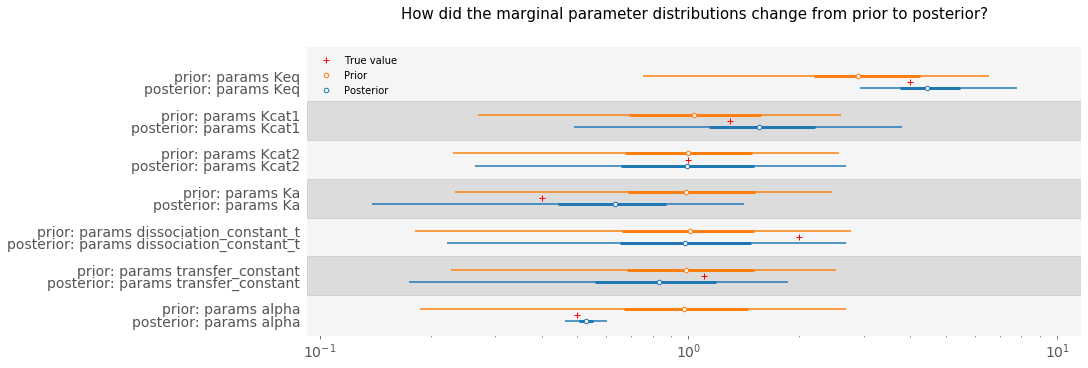

In [10]:
f, [ax] = arviz.plot_forest(
    [infd_prior, infd_posterior],
    combined=True,
    model_names=['prior', 'posterior'],
    var_names=['params'],
    figsize=[15, 5],
    colors=['tab:orange', 'tab:blue']
)
t = ax.set_title('How did the marginal parameter distributions change from prior to posterior?', fontsize=15)
lines = [l for axis in f.axes for l in axis.get_lines()]
for l, true_value in zip(lines[::-2], parameters['true_value'].tolist()):
    y = l.get_ydata()[0] - 1.15
    p = ax.plot(true_value, y, '+', color='r')
ax.legend([p[0], lines[1], lines[0]], ['True value', 'Prior', 'Posterior'], frameon=False, loc='upper left')
ax.semilogx()
plt.show()

The next cell makes a similar plot for the observed metabolite concentrations. Here the convergence towards the true value from prior to posterior is much higher than for the marginal parameter distributions. 

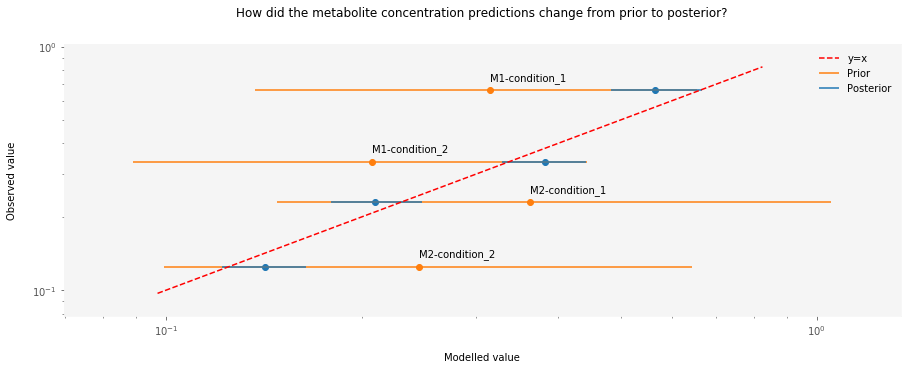

In [12]:
posterior_low, posterior_med, posterior_high = (
    infd_posterior.posterior_predictive['conc_pred'].quantile(q, dim=['chain', 'draw'])
    for q in [0.1, 0.5, 0.9]
)
prior_low, prior_med, prior_high = (
    infd_prior.posterior_predictive['conc_pred'].quantile(q, dim=['chain', 'draw'])
    for q in [0.1, 0.5, 0.9]
)
obs = infd_posterior.observed_data['conc_pred']
x = np.linspace(infd_posterior.posterior_predictive['conc_pred'].min(), 
                infd_posterior.posterior_predictive['conc_pred'].max(), 100)
labels = posterior_med.coords['concentration_measurements']

f, ax = plt.subplots(figsize=[15, 5])

ax.scatter(prior_med, obs, label='', color='tab:orange')
ax.hlines(obs, prior_low, prior_high, color='tab:orange', label='Prior')

ax.scatter(posterior_med, obs, label='', color='tab:blue')
ax.hlines(obs, posterior_low, posterior_high, color='tab:blue', label='Posterior', alpha=1)
for label, observed_value, prior_med_value in zip(labels.values, obs.values, prior_med.values):
    ax.text(prior_med_value, observed_value * 1.1, label)


ax.plot(x, x, color='r', linestyle='--', label='y=x')
ax.semilogx()
ax.semilogy()
legend = ax.legend(frameon=False)
text = ax.set(title='How did the metabolite concentration predictions change from prior to posterior?',
              xlabel='Modelled value',
              ylabel='Observed value')

Finally, the following plot shows the posterior correlation between each parameter. We can see that although there are some correlations, there are no troubling funnel or banana shapes.

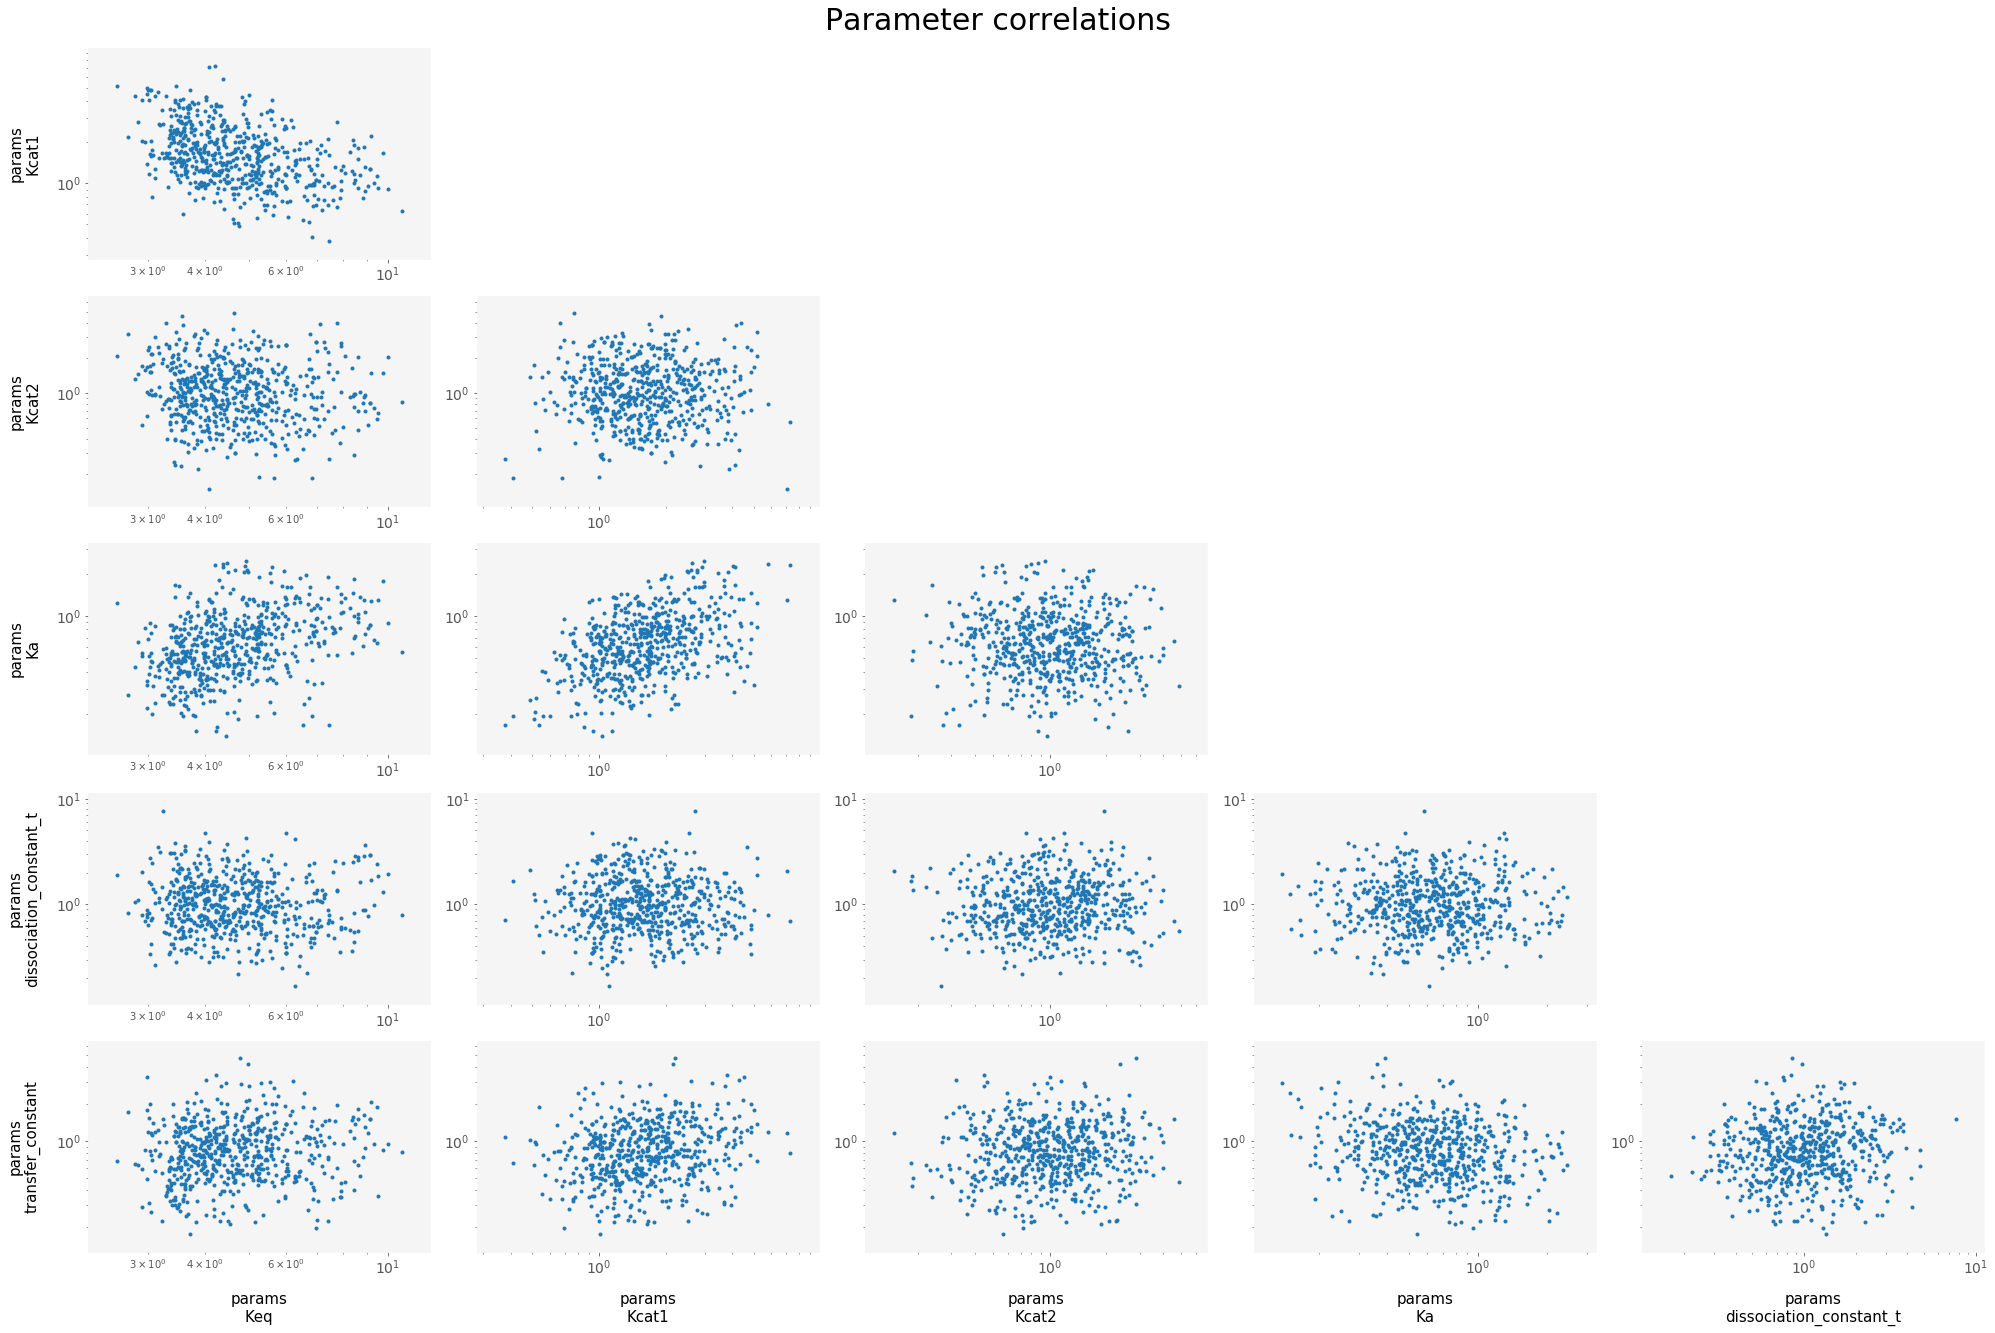

In [13]:
axes = arviz.plot_pair(infd_posterior, var_names=['params'], 
                       coords={'parameter_names': [n for n in parameters['parameter'] if n != 'alpha']})

for ax in axes.ravel():
    ax.semilogx()
    ax.semilogy()

f = plt.gcf()
suptitle = f.suptitle("Parameter correlations", fontsize=30)

## References

Cleland, W. W. 1963. “The Kinetics of Enzyme-Catalyzed Reactions with Two or More Substrates or Products: I. Nomenclature and Rate Equations.” _Biochimica et Biophysica Acta (BBA) - Specialized Section on Enzymological Subjects 67_ (January): 104–37. doi:10.1016/0926-6569(63)90211-6.

Popova, S. V., and E. E. Sel’kov. 1975. “Generalization of the Model by Monod, Wyman and Changeux for the Case of a Reversible Monosubstrate Reaction.” _FEBS Letters_ 53 (3): 269–73. doi:10.1016/0014-5793(75)80034-2.

Saa, Pedro A., and Lars K. Nielsen. 2016. “Construction of Feasible and Accurate Kinetic Models of Metabolism: A Bayesian Approach.” _Scientific Reports_ 6 (1). doi:10.1038/srep29635.

———. 2017. “Formulation, Construction and Analysis of Kinetic Models of Metabolism: A Review of Modelling Frameworks.” _Biotechnology Advances_ 35 (8): 981–1003. doi:10.1016/j.biotechadv.2017.09.005.

Tsigkinopoulou, Areti, Syed Murtuza Baker, and Rainer Breitling. 2017. “Respectful Modeling: Addressing Uncertainty in Dynamic System Models for Molecular Biology.” _Trends in Biotechnology_ 35 (6): 518–29. doi:10.1016/j.tibtech.2016.12.008.
